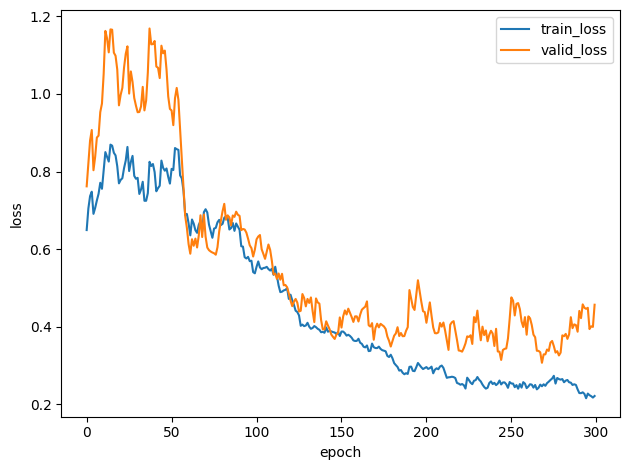

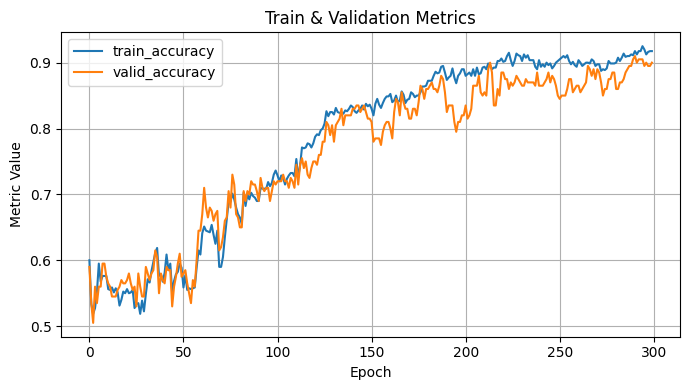

In [3]:
#CLASSIFICATION
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

from pyperch import Perch
from pyperch.models import SimpleMLP
from pyperch.utils import plot_losses, plot_metrics
from pyperch.core.metrics import Accuracy

# -------------------------------------------------------------------
# 1. Reproducibility
# -------------------------------------------------------------------
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# -------------------------------------------------------------------
# 2. Dataset
# -------------------------------------------------------------------
X, y = make_classification(
    n_samples=1000,
    n_features=12,
    n_informative=10,
    n_classes=2,
    random_state=seed,
)

X = X.astype(np.float32)
y = y.astype(np.int64)

# -------------------------------------------------------------------
# 3. Builder: model + data + optimizer
# -------------------------------------------------------------------
perch = (
    Perch()
    .model(
        SimpleMLP,
        input_dim=12,
        hidden=[32],
        output_dim=2,
        activation="relu",
        loss_fn=nn.CrossEntropyLoss(),
    )
    .optimizer(
        "sa",
        t=2.0,
        t_min=0.001,
        cooling=0.995,
        step_size=0.05,
    )
    .metrics(Accuracy())
    .data(
        X,
        y,
        batch_size=64,
        valid_split=0.2,
        stratify=True,
        normalize=None,
    )
)

# -------------------------------------------------------------------
# 4. Train
# -------------------------------------------------------------------
trainer, history = perch.train(
    max_epochs=300,
    seed=seed,
    optimizer_mode="per_batch",   
)

# -------------------------------------------------------------------
# 5. Plots
# -------------------------------------------------------------------
plot_losses(history)
plt.show()

plot_metrics(history)
plt.show()



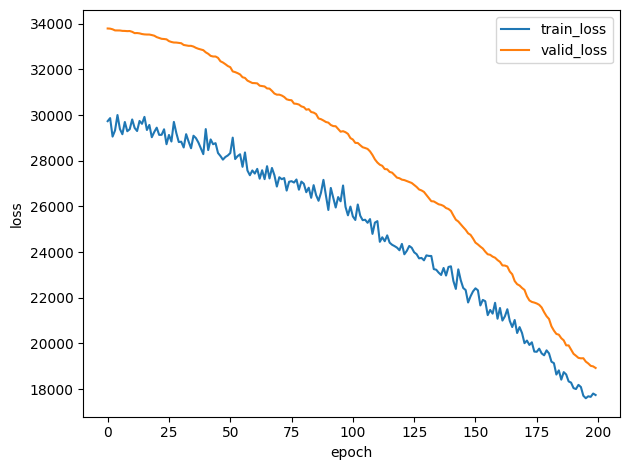

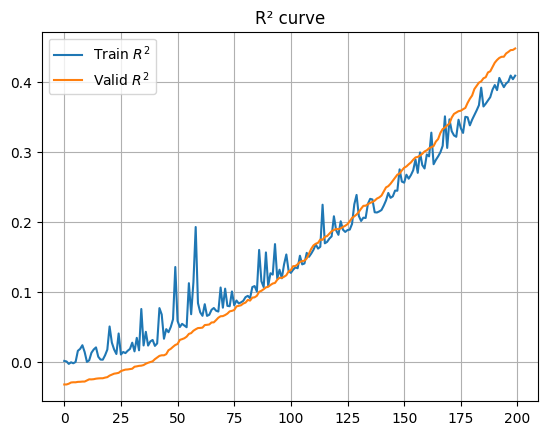

In [5]:
# REGRESSION

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression

from pyperch import Perch
from pyperch.models import SimpleMLP
from pyperch.utils import plot_losses
from pyperch.core.metrics import MSE, R2

# -------------------------------------------------------------------
# 1. Reproducibility
# -------------------------------------------------------------------
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# -------------------------------------------------------------------
# 2. Regression dataset
# -------------------------------------------------------------------
X, y = make_regression(
    n_samples=1000,
    n_features=12,
    noise=0.2,
    random_state=seed,
)

X = X.astype(np.float32)
y = y.reshape(-1, 1).astype(np.float32)

# -------------------------------------------------------------------
# 3. Builder: model + optimizer + data
# -------------------------------------------------------------------
perch = (
    Perch()
    .model(
        SimpleMLP,
        input_dim=12,
        hidden=[32],
        output_dim=1,
        activation="leaky_relu",
        loss_fn=nn.MSELoss(),
    )
    .optimizer(
        "sa",
        t=2.0,
        t_min=0.001,
        cooling=0.995,
        step_size=0.1,      # regression usually benefits from larger steps
    )
    .metrics(MSE(), R2())
    .data(
        X,
        y,
        batch_size=64,
        valid_split=0.2,
        stratify=False,
        normalize=None,
    )
)

# -------------------------------------------------------------------
# 4. Train
# -------------------------------------------------------------------
trainer, history = perch.train(
    max_epochs=200,
    seed=seed,
    optimizer_mode="per_batch",
)

# -------------------------------------------------------------------
# 5. Plots
# -------------------------------------------------------------------
plot_losses(history)
plt.show()

# R² plot (builder stores metrics the same way)
epochs = history["epoch"]
train_r2 = history["train_metrics"].get("r2", [])
valid_r2 = history["valid_metrics"].get("r2", [])

plt.figure()
plt.plot(epochs, train_r2, label="Train $R^2$")
plt.plot(epochs, valid_r2, label="Valid $R^2$")
plt.legend()
plt.grid()
plt.title("R² curve")
plt.show()


Frozen layer unchanged: True


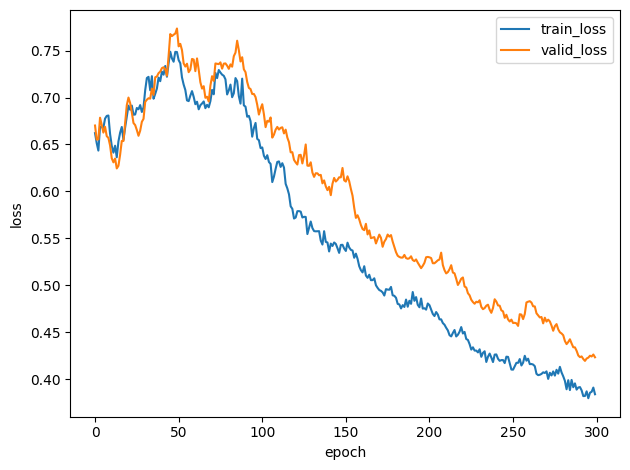

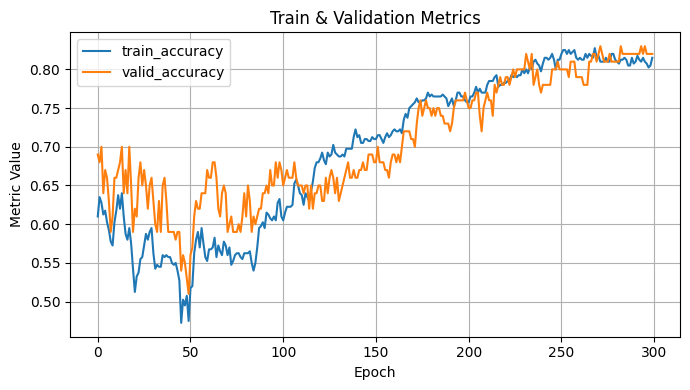

In [1]:
# FREEZING

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

from pyperch import Perch
from pyperch.models import SimpleMLP
from pyperch.utils import plot_losses, plot_metrics
from pyperch.core.callbacks import CaptureInitialWeights

# ------------------------------------------------------------
# Dummy dataset
# ------------------------------------------------------------
np.random.seed(42)
X = np.random.randn(500, 10).astype(np.float32)
y = (X[:, :3].sum(axis=1) > 0).astype(np.int64)

# ------------------------------------------------------------
# Build experiment with SA + freeze + meta
# ------------------------------------------------------------
perch = (
    Perch()
    .model(
        SimpleMLP,
        input_dim=10,
        hidden=[16],
        output_dim=2,
        activation="relu",
        loss_fn=nn.CrossEntropyLoss(),
    )
    .freeze("net.0.weight", "net.0.bias")
    .meta_opt("net.2.weight", "net.2.bias")
    .optimizer(
        "sa",
        t=2.0,
        t_min=0.001,
        cooling=0.995,
        step_size=0.05,
    )
    .metrics("accuracy")
    .data(
        X,
        y,
        batch_size=32,
        valid_split=0.2,
        stratify=False,
    )
)

# ------------------------------------------------------------
# Capture initial frozen weights
# ------------------------------------------------------------
cap = CaptureInitialWeights("net.0.weight")

trainer, history = perch.callbacks(cap).train(
    max_epochs=200,
    seed=42,
    optimizer_mode="per_batch",
)

initial_w0 = cap.initial["net.0.weight"]
final_w0 = trainer.model.net[0].weight.detach()

# ------------------------------------------------------------
# Verify frozen layer did not change
# ------------------------------------------------------------
unchanged = torch.allclose(initial_w0, final_w0)
print("Frozen layer unchanged:", unchanged)

# ------------------------------------------------------------
# Plots
# ------------------------------------------------------------
plot_losses(history)
plt.show()

plot_metrics(history)
plt.show()


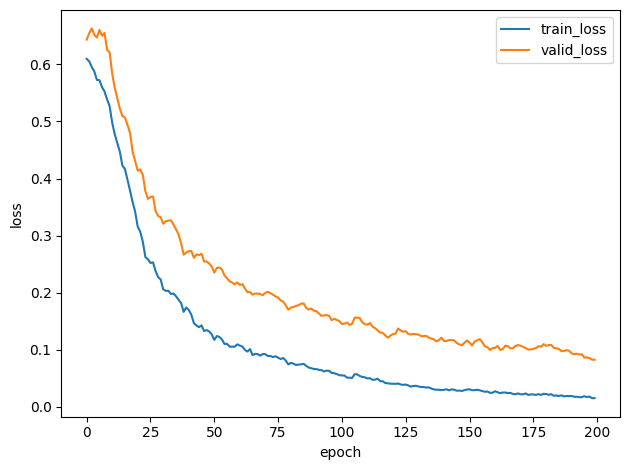

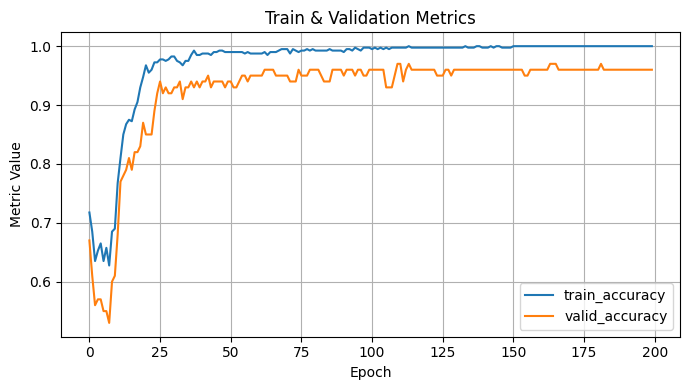

In [2]:
#hybrid test: 

# ------------------------------------------------------------
# Hybrid Layer Modes: grad + meta
# ------------------------------------------------------------
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

from pyperch import Perch
from pyperch.models import SimpleMLP
from pyperch.core.metrics import Accuracy
from pyperch.utils import plot_losses, plot_metrics

# ------------------------------------------------------------
# Dummy dataset
# ------------------------------------------------------------
np.random.seed(42)
torch.manual_seed(42)
X = np.random.randn(500, 10).astype(np.float32)
y = (X[:, :3].sum(axis=1) > 0).astype(np.int64)

# ------------------------------------------------------------
# Hybrid: SA for some layers, Adam (grad) for others
# ------------------------------------------------------------
perch = (
    Perch()
    .model(
        SimpleMLP,
        input_dim=10,
        hidden=[16],
        output_dim=2,
        activation="relu",
        loss_fn=nn.CrossEntropyLoss(),
    )
    # ------------------------------
    # Layer modes
    # ------------------------------
    .grad_opt("net.0.weight", "net.0.bias")     # Gradient-based
    .meta_opt("net.2.weight", "net.2.bias")     # SA-based
    # ------------------------------
    # Optimizers
    # ------------------------------
    .torch_optimizer("adam", lr=1e-3)           # For grad_opt layers
    .optimizer(
        "sa",
        t=2.0,
        t_min=0.001,
        cooling=0.995,
        step_size=0.05,
    )   # For meta_opt layers
    # ------------------------------
    # Metrics + Data
    # ------------------------------
    .metrics("accuracy")
    .data(
        X,
        y,
        batch_size=32,
        valid_split=0.2,
        stratify=False,
    )
)

# ------------------------------------------------------------
# Train
# ------------------------------------------------------------
trainer, history = perch.train(
    max_epochs=200,
    seed=42,
    optimizer_mode="per_batch",
)

# ------------------------------------------------------------
# Plots
# ------------------------------------------------------------
plot_losses(history)
plt.show()

plot_metrics(history)
plt.show()

Frozen layer unchanged: True


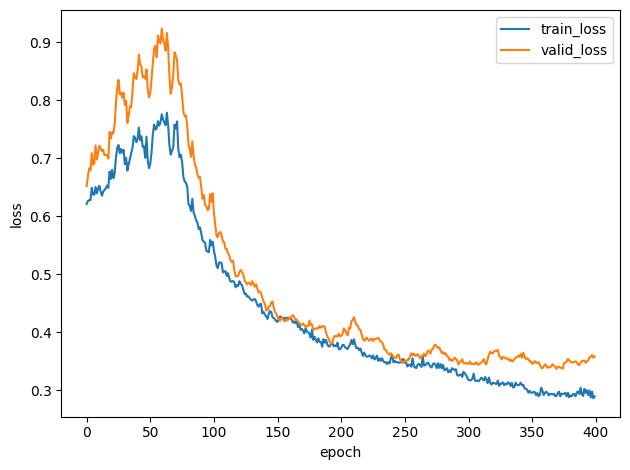

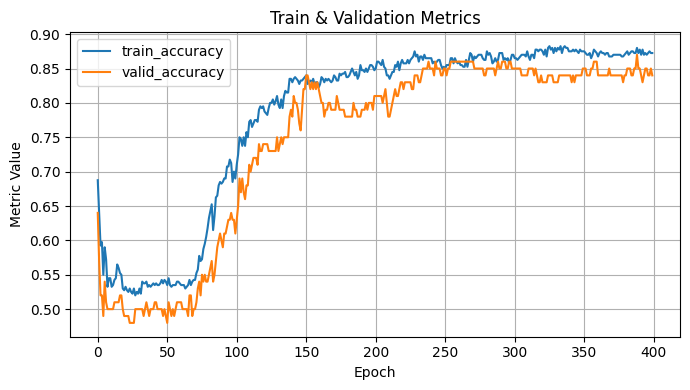

In [3]:
#freeze + hybrid
# ------------------------------------------------------------
# Freeze first layer
# Train middle with Adam
# Train output with SA
# ------------------------------------------------------------

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

from pyperch import Perch
from pyperch.models import SimpleMLP
from pyperch.core.metrics import Accuracy
from pyperch.utils import plot_losses, plot_metrics
from pyperch.core.callbacks import CaptureInitialWeights

# ------------------------------------------------------------
# Dummy dataset
# ------------------------------------------------------------
np.random.seed(42)
torch.manual_seed(42)
X = np.random.randn(500, 10).astype(np.float32)
y = (X[:, :3].sum(axis=1) > 0).astype(np.int64)

# ------------------------------------------------------------
# Build FREEZE + SA hybrid model
# ------------------------------------------------------------
perch = (
    Perch()
    .model(
        SimpleMLP,
        input_dim=10,
        hidden=[16],
        output_dim=2,
        activation="relu",
        loss_fn=nn.CrossEntropyLoss(),
    )
    # ------------------------------
    # Layer modes
    # ------------------------------
    .freeze("net.0.weight", "net.0.bias")        # FROZEN LAYER
    .meta_opt("net.2.weight", "net.2.bias")      # SA-optimized layer
    # ------------------------------
    # Optimizer (meta)
    # ------------------------------
    .optimizer(
        "sa",
        t=2.0,
        t_min=0.001,
        cooling=0.995,
        step_size=0.05,
    )
    # ------------------------------
    # Metrics + Data
    # ------------------------------
    .metrics("accuracy")
    .data(
        X,
        y,
        batch_size=32,
        valid_split=0.2,
        stratify=False,
    )
)

# ------------------------------------------------------------
# Capture initial frozen weights (to verify freezing)
# ------------------------------------------------------------
cap = CaptureInitialWeights("net.0.weight")

trainer, history = perch.callbacks(cap).train(
    max_epochs=400,
    seed=42,
    optimizer_mode="per_batch",
)

initial = cap.initial["net.0.weight"]
final = trainer.model.net[0].weight.detach()

print("Frozen layer unchanged:", torch.allclose(initial, final))

# ------------------------------------------------------------
# Plots
# ------------------------------------------------------------
plot_losses(history)
plt.show()

plot_metrics(history)
plt.show()
